In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import datetime
from sklearn.preprocessing import MinMaxScaler

# Set random seed for reproducibility
np.random.seed(1234)
tf.random.set_seed(1234)

# Download the Covid-19 infection dataset from S. Korea
import urllib.request

url = "https://raw.githubusercontent.com/abhisoni24/seir-pinn-hybrid/refs/heads/main/SEIR-PINN/KOR.csv"
filename = "KOR.csv"
urllib.request.urlretrieve(url, filename)

# Load and process the South Korea COVID-19 data
data = pd.read_csv('KOR.csv')

# Clean data by removing empty rows
data = data.dropna(subset=['date', 'confirmed', 'deaths', 'recovered'])

# Convert date to datetime and extract days since first case
data['date'] = pd.to_datetime(data['date'])
data['days'] = (data['date'] - data['date'].min()).dt.days

# We'll use these variables for modeling
days = data['days'].values
confirmed = data['confirmed'].values
deaths = data['deaths'].values        # Part of R
recovered = data['recovered'].values  # Part of R
population = data['population'].values[0]  # Total population N

# Create infectious (I) by subtracting recovered and deaths from confirmed
data['infectious'] = data['confirmed'] - data['recovered'] - data['deaths']
infectious = data['infectious'].values

# Normalize time for better training
t_max = days.max()
days_norm = days / t_max

# Create t for PINN collocation points (more dense than the data points)
t_collocation = np.linspace(0, 1, 1000, dtype=np.float32)[:, None]  # Normalized time, **dtype specified here**

# Scale the data values to [0, 1] for better training
scaler_S = MinMaxScaler()
scaler_E = MinMaxScaler()
scaler_I = MinMaxScaler()
scaler_R = MinMaxScaler()

# We don't have direct E data, but we scale I and R
I_scaled = scaler_I.fit_transform(infectious.reshape(-1, 1))
R_scaled = scaler_R.fit_transform((recovered + deaths).reshape(-1, 1))

# For S, we assume initial value is population - initial confirmed
S_initial = population - confirmed[0]
S_final = population - confirmed[-1]
scaler_S.fit(np.array([S_initial, S_final]).reshape(-1, 1))

# For E, we'll just use a reasonable range
scaler_E.fit(np.array([0, confirmed.max() * 0.1]).reshape(-1, 1))

# Prepare data for training
X_data = days_norm.reshape(-1, 1).astype(np.float32)  # Convert to float32
y_data_I = I_scaled
y_data_R = R_scaled

print(f"Data shape: {X_data.shape}, I shape: {y_data_I.shape}, R shape: {y_data_R.shape}")
print(f"Data range: {X_data.min()} to {X_data.max()}")
print(f"Population: {population}")

Data shape: (561, 1), I shape: (561, 1), R shape: (561, 1)
Data range: 0.0 to 1.0
Population: 51606633.0


In [4]:
def create_pinn_model():
    """Create the PINN model for SEIR dynamics"""
    # Input layer - time
    t_input = Input(shape=(1,), name='time_input')

    # Hidden layers with tanh activation for smooth derivatives
    x = Dense(32, activation='tanh')(t_input)
    x = Dense(64, activation='tanh')(x)
    x = Dense(64, activation='tanh')(x)
    x = Dense(32, activation='tanh')(x)

    # Output layers for S, E, I, R - no activation to allow any range
    S = Dense(1, activation=None, name='S')(x)
    E = Dense(1, activation=None, name='E')(x)
    I = Dense(1, activation=None, name='I')(x)
    R = Dense(1, activation=None, name='R')(x)

    # Create the model
    model = Model(inputs=t_input, outputs=[S, E, I, R])
    return model

# Create the model
pinn_model = create_pinn_model()
pinn_model.summary()

# Initial condition data (day 0)
S0_scaled = scaler_S.transform(np.array([population - confirmed[0]]).reshape(1, 1))[0, 0]
E0_scaled = 0.0  # We don't know, assume 0 initially
I0_scaled = I_scaled[0, 0]
R0_scaled = R_scaled[0, 0]

print(f"Initial conditions (scaled): S0={S0_scaled}, E0={E0_scaled}, I0={I0_scaled}, R0={R0_scaled}")

# The SEIR model parameters (to be learned or initialized)
beta = tf.Variable(0.5, dtype=tf.float32, name='beta')  # infection rate
sigma = tf.Variable(0.2, dtype=tf.float32, name='sigma')  # incubation rate
gamma = tf.Variable(0.1, dtype=tf.float32, name='gamma')  # recovery rate

@tf.function
def pinn_dynamics(t, training=False):
    """Compute SEIR predicted values and their derivatives for physics loss"""
    t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)

    # Get model predictions for S, E, I, R
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t_tensor)
        S, E, I, R = pinn_model(t_tensor, training=training)

    # Calculate derivatives with respect to time
    dS_dt = tape.gradient(S, t_tensor)
    dE_dt = tape.gradient(E, t_tensor)
    dI_dt = tape.gradient(I, t_tensor)
    dR_dt = tape.gradient(R, t_tensor)

    del tape

    return S, E, I, R, dS_dt, dE_dt, dI_dt, dR_dt

@tf.function
def physics_loss():
    """Calculate physics-informed loss based on SEIR differential equations"""
    # Get predictions and derivatives at collocation points
    S, E, I, R, dS_dt, dE_dt, dI_dt, dR_dt = pinn_dynamics(t_collocation)

    # SEIR equations (N = 1 in scaled form)
    N = 1.0  # Since we're working with normalized values

    # SEIR differential equations
    dS_dt_physics = -beta * S * I / N
    dE_dt_physics = beta * S * I / N - sigma * E
    dI_dt_physics = sigma * E - gamma * I
    dR_dt_physics = gamma * I

    # Physics loss: mean squared error between computed derivatives and physics-based derivatives
    S_loss = tf.reduce_mean(tf.square(dS_dt - dS_dt_physics))
    E_loss = tf.reduce_mean(tf.square(dE_dt - dE_dt_physics))
    I_loss = tf.reduce_mean(tf.square(dI_dt - dI_dt_physics))
    R_loss = tf.reduce_mean(tf.square(dR_dt - dR_dt_physics))

    # Total physics loss
    return S_loss + E_loss + I_loss + R_loss

@tf.function
def data_loss():
    """Calculate data-fitting loss for observed I and R"""
    # Get predictions at data points
    S_pred, E_pred, I_pred, R_pred, _, _, _, _ = pinn_dynamics(X_data)

    # Data loss: mean squared error between predictions and observations
    I_loss = tf.reduce_mean(tf.square(I_pred - y_data_I))
    R_loss = tf.reduce_mean(tf.square(R_pred - y_data_R))

    return I_loss + R_loss

@tf.function
def initial_condition_loss():
    """Calculate loss for initial conditions"""
    # Get predictions at t=0
    t0 = tf.zeros((1, 1), dtype=tf.float32)
    S_pred, E_pred, I_pred, R_pred, _, _, _, _ = pinn_dynamics(t0)

    # Initial condition loss
    S0_loss = tf.square(S_pred[0, 0] - S0_scaled)
    E0_loss = tf.square(E_pred[0, 0] - E0_scaled)
    I0_loss = tf.square(I_pred[0, 0] - I0_scaled)
    R0_loss = tf.square(R_pred[0, 0] - R0_scaled)

    return S0_loss + E0_loss + I0_loss + R0_loss

@tf.function
def conservation_loss():
    """Ensure S + E + I + R = N (normalized to 1.0)"""
    # Get predictions at collocation points
    S, E, I, R, _, _, _, _ = pinn_dynamics(t_collocation)

    # Conservation loss: S + E + I + R should equal 1 (normalized total population)
    return tf.reduce_mean(tf.square((S + E + I + R) - 1.0))

@tf.function
def total_loss():
    """Combine all loss components"""
    phys_loss = physics_loss()
    dat_loss = data_loss()
    ic_loss = initial_condition_loss()
    cons_loss = conservation_loss()

    # Weighting the different loss components
    lambda_physics = 1.0
    lambda_data = 10.0
    lambda_ic = 10.0
    lambda_conservation = 5.0

    return (lambda_physics * phys_loss +
            lambda_data * dat_loss +
            lambda_ic * ic_loss +
            lambda_conservation * cons_loss)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ time_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │             64 │ time_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          2,112 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          4,160 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ S (Dense)                 │ (None, 1)              │             33 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ E (Dense)                 │ (None, 1)              │             33 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ I (Dense)                 │ (None, 1)              │             33 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ R (Dense)                 │ (None, 1)              │             33 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,548 (33.39 KB)

 Trainable params: 8,548 (33.39 KB)

 Non-trainable params: 0 (0.00 B)

Initial conditions (scaled): S0=1.0, E0=0.0, I0=0.0, R0=0.0


In [5]:
# Define optimizer
optimizer = Adam(learning_rate=0.001)

# Training loop
epochs = 20000
print_every = 1000
history = {
    'total_loss': [],
    'physics_loss': [],
    'data_loss': [],
    'ic_loss': [],
    'conservation_loss': [],
    'beta': [],
    'sigma': [],
    'gamma': []
}

@tf.function
def train_step():
    """Single training step with gradient calculation and optimization"""
    with tf.GradientTape() as tape:
        loss = total_loss()

    # Get gradients and perform optimization
    gradients = tape.gradient(loss, pinn_model.trainable_variables + [beta, sigma, gamma])
    optimizer.apply_gradients(zip(gradients, pinn_model.trainable_variables + [beta, sigma, gamma]))

    return loss

# Training loop
for epoch in range(epochs):
    loss_value = train_step()

    # Record loss history
    if epoch % print_every == 0 or epoch == epochs - 1:
        # Calculate individual loss components for tracking
        phys_loss = physics_loss()
        dat_loss = data_loss()
        ic_loss = initial_condition_loss()
        cons_loss = conservation_loss()

        history['total_loss'].append(loss_value.numpy())
        history['physics_loss'].append(phys_loss.numpy())
        history['data_loss'].append(dat_loss.numpy())
        history['ic_loss'].append(ic_loss.numpy())
        history['conservation_loss'].append(cons_loss.numpy())
        history['beta'].append(beta.numpy())
        history['sigma'].append(sigma.numpy())
        history['gamma'].append(gamma.numpy())

        print(f"Epoch {epoch}/{epochs}, Loss: {loss_value.numpy():.6f}, "
              f"Physics Loss: {phys_loss.numpy():.6f}, Data Loss: {dat_loss.numpy():.6f}, "
              f"β: {beta.numpy():.4f}, σ: {sigma.numpy():.4f}, γ: {gamma.numpy():.4f}")

# Print final learned parameters
print(f"\nLearned parameters:")
print(f"β (transmission rate): {beta.numpy():.6f}")
print(f"σ (incubation rate): {sigma.numpy():.6f}")
print(f"γ (recovery rate): {gamma.numpy():.6f}")

# Convert rates to meaningful epidemiological parameters
print(f"\nEpidemiological interpretations:")
print(f"R₀ (basic reproduction number): {beta.numpy() / gamma.numpy():.6f}")
print(f"1/σ (average incubation period in days): {t_max / sigma.numpy():.6f} days")
print(f"1/γ (average infectious period in days): {t_max / gamma.numpy():.6f} days")

Epoch 0/20000, Loss: 16.048605, Physics Loss: 0.146799, Data Loss: 0.110503, β: 0.5010, σ: 0.1990, γ: 0.1010
Epoch 1000/20000, Loss: 0.800705, Physics Loss: 0.284815, Data Loss: 0.045251, β: -0.4090, σ: -0.9898, γ: 1.1528
Epoch 2000/20000, Loss: 0.477307, Physics Loss: 0.123061, Data Loss: 0.031387, β: -1.0002, σ: -1.8138, γ: 2.3275
Epoch 3000/20000, Loss: 0.361859, Physics Loss: 0.056616, Data Loss: 0.027822, β: -1.0796, σ: -2.2913, γ: 3.1599
Epoch 4000/20000, Loss: 0.324981, Physics Loss: 0.039110, Data Loss: 0.026761, β: -0.9796, σ: -2.6148, γ: 3.7635
Epoch 5000/20000, Loss: 0.311326, Physics Loss: 0.029846, Data Loss: 0.026548, β: -0.7234, σ: -2.8591, γ: 4.1721
Epoch 6000/20000, Loss: 0.307583, Physics Loss: 0.034563, Data Loss: 0.026647, β: -0.3965, σ: -3.0532, γ: 4.4137
Epoch 7000/20000, Loss: 0.303019, Physics Loss: 0.023829, Data Loss: 0.026602, β: 0.0080, σ: -3.2226, γ: 4.5183
Epoch 8000/20000, Loss: 0.300361, Physics Loss: 0.022405, Data Loss: 0.026516, β: 0.4640, σ: -3.3902,

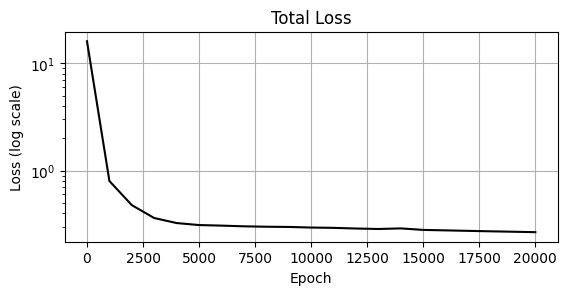

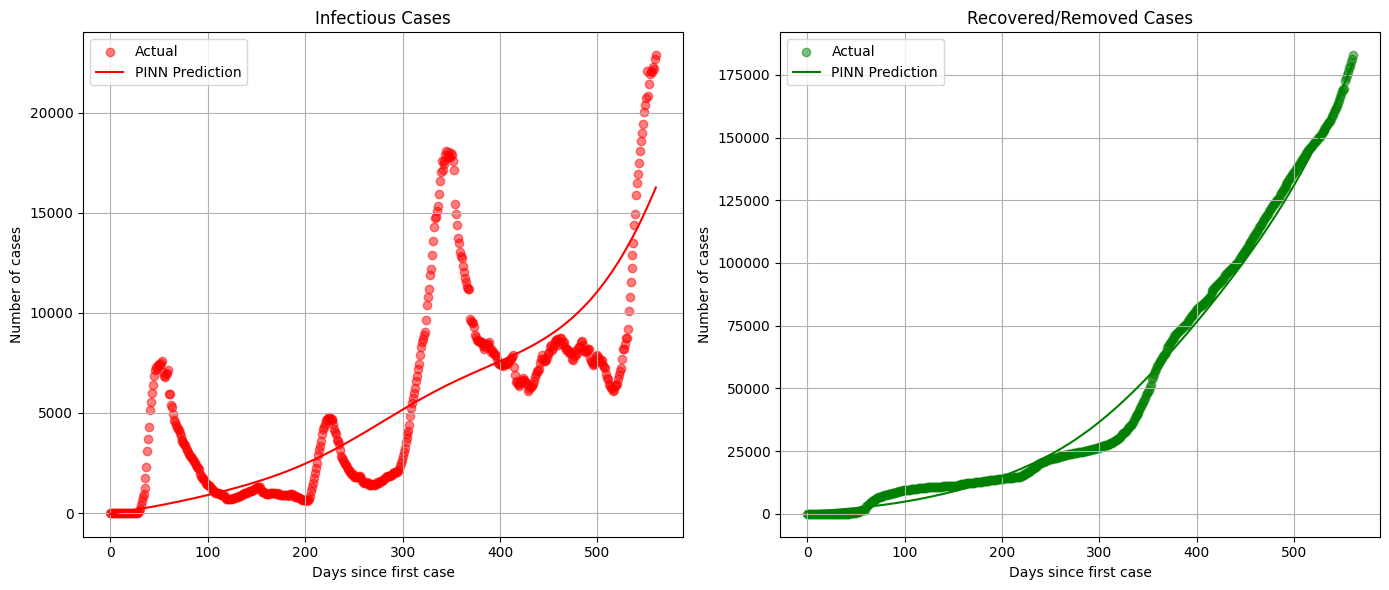

In [25]:
# Generate predictions over the full time range
t_pred = np.linspace(0, 1, 500, dtype=np.float32)[:, None]  # Normalized time, **dtype specified here**
S_pred, E_pred, I_pred, R_pred, _, _, _, _ = pinn_dynamics(t_pred)


# Convert predictions back to original scale
S_pred_orig = scaler_S.inverse_transform(S_pred.numpy())
E_pred_orig = scaler_E.inverse_transform(E_pred.numpy())
I_pred_orig = scaler_I.inverse_transform(I_pred.numpy())
R_pred_orig = scaler_R.inverse_transform(R_pred.numpy())

# Plot loss history
plt.figure(figsize=(14, 6))

plt.subplot(2, 2, 1)
plt.semilogy(range(0, epochs + print_every, print_every)[:len(history['total_loss'])], history['total_loss'], 'k-')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.grid(True)

# Plot comparison of model fit with actual data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(days, infectious, color='red', marker='o', alpha=0.5, label='Actual')
plt.plot(t_orig, I_pred_orig, 'r-', label='PINN Prediction')
plt.title('Infectious Cases')
plt.xlabel('Days since first case')
plt.ylabel('Number of cases')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(days, recovered + deaths, color='green', marker='o', alpha=0.5, label='Actual')
plt.plot(t_orig, R_pred_orig, 'g-', label='PINN Prediction')
plt.title('Recovered/Removed Cases')
plt.xlabel('Days since first case')
plt.ylabel('Number of cases')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('pinn_data_fit.png', dpi=300, bbox_inches='tight')
plt.show()

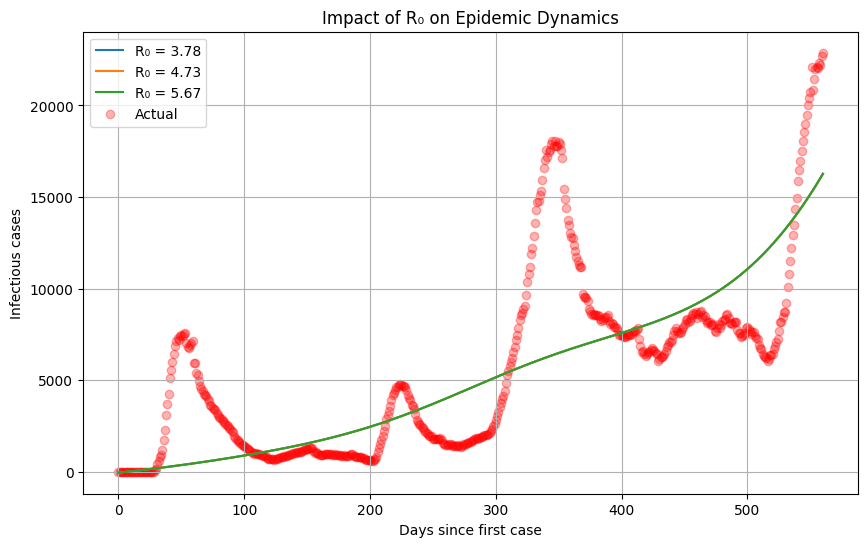


===== PINN-SEIR Model Results for South Korea COVID-19 Data =====
Basic reproduction number (R₀): 4.7268


In [27]:
def predict_with_params(beta_val, sigma_val, gamma_val):

    """Generate predictions using specific parameter values"""
    # Set the parameter values
    beta.assign(beta_val)
    sigma.assign(sigma_val)
    gamma.assign(gamma_val)

    # Generate predictions
    # Changed: Explicitly specify dtype=np.float32
    t_pred = np.linspace(0, 1, 500, dtype=np.float32)[:, None]
    S_pred, E_pred, I_pred, R_pred, _, _, _, _ = pinn_dynamics(t_pred)

    # Convert to original scale
    S_pred_orig = scaler_S.inverse_transform(S_pred.numpy())
    E_pred_orig = scaler_E.inverse_transform(E_pred.numpy())
    I_pred_orig = scaler_I.inverse_transform(I_pred.numpy())
    R_pred_orig = scaler_R.inverse_transform(R_pred.numpy())

    return S_pred_orig, E_pred_orig, I_pred_orig, R_pred_orig

# Get the best-fit parameters
best_beta = beta.numpy()
best_sigma = sigma.numpy()
best_gamma = gamma.numpy()

# Parameter variations for sensitivity analysis
beta_variations = [best_beta * 0.8, best_beta, best_beta * 1.2]
sigma_variations = [best_sigma * 0.8, best_sigma, best_sigma * 1.2]
gamma_variations = [best_gamma * 0.8, best_gamma, best_gamma * 1.2]

# Create time vector for x-axis
t_orig = np.linspace(0, t_max, 500)

# Compute R0 and its impact
r0_values = np.array(beta_variations) / best_gamma
plt.figure(figsize=(10, 6))
for i, r0 in enumerate(r0_values):
    S, E, I, R = predict_with_params(beta_variations[i], best_sigma, best_gamma)
    plt.plot(t_orig, I, label=f'R₀ = {r0:.2f}')
plt.scatter(days, infectious, color='red', marker='o', alpha=0.3, label='Actual')
plt.title('Impact of R₀ on Epidemic Dynamics')
plt.xlabel('Days since first case')
plt.ylabel('Infectious cases')
plt.legend()
plt.grid(True)
plt.savefig('r0_impact.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary of findings
print("\n===== PINN-SEIR Model Results for South Korea COVID-19 Data =====")
print(f"Basic reproduction number (R₀): {best_beta / best_gamma:.4f}")
print("================================================================")